In [1]:
import networkx as nx
import copy
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from osmnx.save_load import graph_to_gdfs
import os
from itertools import islice
import pickle

%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

# Overview

1) Given a city, loads speed data and downloads the street network covering the appropriate area, and merge the data to save as a street network graph in graphML format in `/experiments/graphs`.

2) Converts street networks in `/experiments/graphs` to line graphs in `/experiments/line_graphs`.

## Configure

In [2]:
run_label = "new_york"

In [3]:
config = pd.read_csv("config.csv", quotechar='"', skipinitialspace=True)

config.set_index("label", inplace=True)

In [4]:
assert run_label in config.index
config

,address,buffer
label,,
san_francisco,"San Francisco, California, USA",10000
new_york,"New York City, New York, USA",10


In [5]:
# movement data
movement_data_dir = "./data/movement_data/"
quarterly_data_fname = "movement-speeds-quarterly-by-hod-" + run_label.replace('_', '-') + "-2019-Q2.csv.zip"
assert os.path.isfile(movement_data_dir + quarterly_data_fname)

## Load Movement Data

In [6]:
%time df_raw = pd.read_csv(movement_data_dir + quarterly_data_fname, engine='c', compression='zip')

CPU times: user 3.71 s, sys: 155 ms, total: 3.86 s
Wall time: 3.86 s


In [7]:
df = df_raw
print("Rows in data: {}".format(len(df)))
df = df[(df['year'] == 2019) &
        (df['quarter'] == 2) &
        (df['hour_of_day'] == 12)]
print("Rows in day data: {}".format(len(df)))

Rows in data: 2607805
Rows in day data: 112419


## Download Graph

In [8]:
%time G = ox.graph_from_place(config.loc[run_label, "address"], network_type='drive', simplify=True, name=run_label, buffer_dist=config.loc[run_label, "buffer"])

CPU times: user 39.9 s, sys: 346 ms, total: 40.2 s
Wall time: 40.2 s


In [9]:
#remove parallel roads
for u,v,key,dat in list(G.edges(data=True,keys=True)):
    if key != 0:
        G.remove_edge(u,v,key)

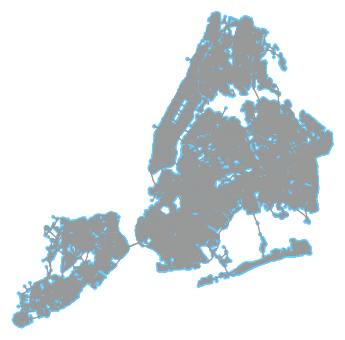

New York City, New York, USA


In [10]:
ox.plot_graph(G)
print(G.graph['name'])

In [11]:
print(G.number_of_nodes())
print(G.number_of_edges())

55356
140783


## Join Data

In [12]:
# osmid column has multiple ids for some roads, this puts single
# ids in a list so that the column has uniform "type" [Int]
def make_uniform_osmid(ids):
    if type(ids) == int:
        return [ids]
    else:
        return ids
    
def parse_maxspeed(speed):
    if type(speed) == str:
        if speed[-4:] == ' mph':
            return float(speed[:-4])
    return np.NaN

def make_uniform_oneway(oneway):
    if type(oneway) == list:
        return oneway[0]
    else:
        return oneway
    
gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
gdf_edges['osmid'] = gdf_edges['osmid'].map(make_uniform_osmid)
gdf_edges['maxspeed'] = gdf_edges['maxspeed'].map(parse_maxspeed)
gdf_edges['oneway'] = gdf_edges['oneway'].map(make_uniform_oneway)

In [13]:
gdf_edges.dtypes

u              int64
v              int64
key            int64
osmid         object
maxspeed     float64
name          object
highway       object
oneway          bool
length       float64
geometry    geometry
lanes         object
access        object
ref           object
bridge        object
tunnel        object
width         object
junction      object
service       object
dtype: object

### Inspect Node Overlap

In [14]:
nodes_in_data = set(df['osm_start_node_id']) | set(df['osm_end_node_id'])
print("Movement data for {} nodes".format(len(nodes_in_data)))
nodes_in_graph = set(gdf_nodes['osmid'])
print("Graph data for {} nodes".format(len(nodes_in_graph)))

Movement data for 60047 nodes
Graph data for 55356 nodes


In [15]:
print("intersection: {} ({})".format(len(nodes_in_data & nodes_in_graph),
                                     len(nodes_in_data & nodes_in_graph) / len(nodes_in_graph)))

intersection: 42903 (0.7750379362670713)


### Inspect Edge Overlap

In [16]:
edges_in_graph = set([e for es in gdf_edges['osmid'] for e in es])
print("Graph data for {} edges".format(len(edges_in_graph)))
edges_in_data = set(df['osm_way_id'])
print("Movement data for {} edges".format(len(edges_in_data)))

Graph data for 47866 edges
Movement data for 33229 edges


In [17]:
print("intersection: {} ({})".format(len(edges_in_data & edges_in_graph),
                                     len(edges_in_data & edges_in_graph) / len(edges_in_graph)))

intersection: 32875 (0.6868131868131868)


### Inspect Node Pairs Overlap

In [18]:
pairs_in_graph = set(list(zip(gdf_edges['u'], gdf_edges['v'])))
print("Graph data for {} pairs".format(len(pairs_in_graph)))
pairs_in_data = set(list(zip(df['osm_start_node_id'], df['osm_end_node_id'])))
print("Movement data for {} pairs".format(len(pairs_in_data)))

Graph data for 140783 pairs
Movement data for 112373 pairs


In [19]:
print("intersection: {} ({})".format(len(pairs_in_data & pairs_in_graph),
                                     len(pairs_in_data & pairs_in_graph) / len(pairs_in_graph)))

intersection: 72841 (0.5173991177912106)


### Join Data on Edge Overlaps

In [20]:
# expand graph edges dataframe w/ one osmid per row
# note call to DataFrame since explode doesn't seem to work with GeoDataFrame
gdf_expanded_edges = pd.DataFrame(gdf_edges).explode('osmid')

In [21]:
# merge on osm way ids
gdf_expanded_edges_merged = gdf_expanded_edges.merge(
    df,
    left_on='osmid',
    right_on='osm_way_id',
    how='left')

# take means across duplicate edges
gdf_edges_merged = gdf_expanded_edges_merged.groupby(
    ['u', 'v', 'key']).mean().reset_index()

# merge speeds back into original edge data
gdf_edges_merged = gdf_edges.merge(
    gdf_edges_merged[['u', 'v', 'key',
                      'speed_mph_mean',
                      'speed_mph_stddev',
                      'speed_mph_p50',
                      'speed_mph_p85']],
    on=['u', 'v', 'key'],
    validate='one_to_one')

In [22]:
gdf_edges_merged.shape

(140783, 22)

In [23]:
gdf_edges.shape

(140783, 18)

In [24]:
gdf_edges_merged.dtypes

u                      int64
v                      int64
key                    int64
osmid                 object
maxspeed             float64
name                  object
highway               object
oneway                  bool
length               float64
geometry            geometry
lanes                 object
access                object
ref                   object
bridge                object
tunnel                object
width                 object
junction              object
service               object
speed_mph_mean       float64
speed_mph_stddev     float64
speed_mph_p50        float64
speed_mph_p85        float64
dtype: object

In [25]:
print("{}/{} ({}) edges have speed data".format(
    (~gdf_edges_merged['speed_mph_mean'].isna()).sum(),
    len(gdf_edges_merged['speed_mph_mean']),
    (~gdf_edges_merged['speed_mph_mean'].isna()).sum() / len(gdf_edges_merged['speed_mph_mean'])))

97699/140783 (0.6939687320202013) edges have speed data


## Rebuild Graph and Examine

In [26]:
G = ox.save_load.gdfs_to_graph(gdf_nodes, gdf_edges_merged)

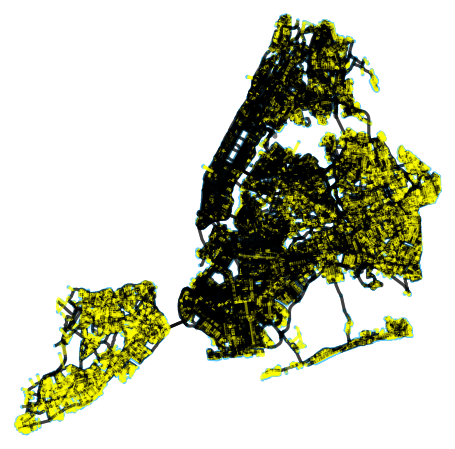

In [27]:
ec = ['black' if 'speed_mph_mean' in d.keys() else 'yellow' for (u,v,d) in G.edges(data=True)]
#ez = [3 if 'speed_mph_mean' in d.keys() else 4 for (u,v,d) in G.edges(data=True)]

fig, ax = ox.plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=0.5)

## Save Street Graph

In [28]:
pickle_out = open('./experiments/graphs/' + run_label +  ".pkl", "wb")
pickle.dump(G, pickle_out)
pickle_out.close()

## Create Line Graph

In [29]:
pickle_in = open('./experiments/graphs/' + run_label +  ".pkl", "rb")
G = pickle.load(pickle_in)

In [30]:
def line_graph(G):
    G = nx.DiGraph(G)
    LG = nx.line_graph(G)
    
    #New Ids are used starting at zero to prevent overflow problem when using snap node2vec
    IDs = {}
    cur_ID = 0
    required_node_features = ['length', 'oneway']
    optional_node_features = ['speed_mph_mean', 'speed_mph_p50', 'speed_mph_p85', 'speed_mph_stddev']

    lg_node_attr = {}
    node_relabel = {}

    remove = []
    for key,_ in LG.nodes(data=True):
        new_edge_data = G.get_edge_data(key[0],key[1])
        skip = False
        for k in list(new_edge_data.keys()):
            if k not in required_node_features + optional_node_features:
                del new_edge_data[k]
        
        for k in required_node_features:
            if k not in new_edge_data:
                skip = True
                break
        if skip == True:
            remove.append(key)
            continue
        new_edge_data['source'] = key[0]
        new_edge_data['sink'] = key[1]
        lg_node_attr[cur_ID] = new_edge_data
        node_relabel[key] = cur_ID
        IDs[cur_ID] = key
        cur_ID+=1

    for i in remove:
        LG.remove_node(i)
    
    nx.relabel.relabel_nodes(LG, node_relabel, False)
    nx.set_node_attributes(LG, lg_node_attr)
        
    return LG

In [31]:
LG = line_graph(G)

In [32]:
pickle_out = open('./experiments/line_graphs/' + run_label +  ".pkl", "wb")
pickle.dump(LG, pickle_out)
pickle_out.close()

In [33]:
pickle_in = open('./experiments/line_graphs/' + run_label +  ".pkl", "rb")
LG = pickle.load(pickle_in)

In [34]:
run_label

'new_york'